# 使用块的网络（VGG）

## VGG 块

In [1]:
import torch
from torch import nn 
import sys
sys.path.append(r"/Users/kingsleycheng/Documents/github/UCAS/DeepLearning/mytorch/")
import mytorch

def vgg_block(num_convs, in_channels, out_channels):
    """
    num_convs:卷积层的数量
    in_channels:输入通道数量
    out_channels: 输出通道数量
    """
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

## VGG 网络

In [2]:
# 每个VGG块中卷积层个数与输出通道参数
conv_arch = ((1,64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(*conv_blks,nn.Flatten(),
                         nn.Linear(out_channels*7*7, 4096), nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(4096, 4096), nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(4096, 10))

net = vgg(conv_arch)

X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,"output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


## 训练模型

loss 0.176, train acc 0.935, test acc 0.912
556.5 examples/sec on mps


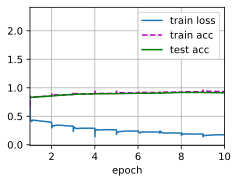

In [3]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = mytorch.load_data_fashion_mnist(batch_size, resize=224)
mytorch.train_ch6(net, train_iter, test_iter, num_epochs,lr, mytorch.try_gpu())